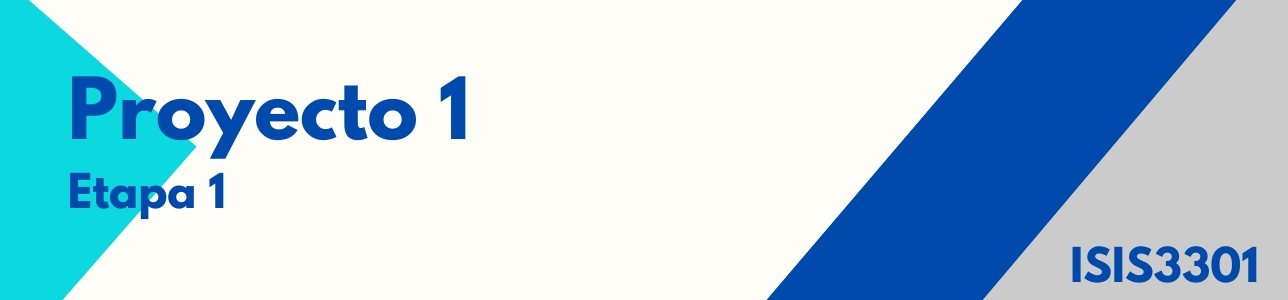

# 1. Instalación e importación de librerías.

In [ ]:
# Librerías para manejo de datos
import pandas as pd
pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Numero máximo de filas a mostar
import numpy as np
np.random.seed(3301)
import pandas as pd
# Para preparar los datos
from sklearn.preprocessing import LabelEncoder
# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
#Para crear el KNN
from sklearn.neighbors import KNeighborsClassifier
#Para estándarizar el modelo
from sklearn.preprocessing import StandardScaler
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
#from sklearn.metrics import plot_confusion_matrix
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold
#Librerías para la visualización
import matplotlib.pyplot as plt
# Seaborn
import joblib
from sklearn.pipeline import Pipeline

import seaborn as sns
from sklearn import tree

# 2. Carga y preparación de datos.

Se importa el archivo CSV que se preparó anteriormente.

In [ ]:
ODS_df = pd.read_csv('data/ods_data.csv', sep=',', encoding = 'UTF-8')
ODS_df.shape

(3839, 11426)

In [ ]:
ODS_df.head()

,Unnamed: 0,sdg,0,1,3,4,5,6,7,8,9,1.1,...,zimbabw,znwl,zogl,zoles,zoll,zomb,zon,zonmw,zuck,zukowski,zupanc,zusatzentgelt
0,0,3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
1,1,3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
2,2,3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
3,3,3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


A pesar de que no es visible en la nuestra del dataframe, hay columnas que cuentan con valores NaN (Not a Number), es posible que esto se deba a un error en el proceso de _stemming_. Para este proceso, se va a tomar la suposición de que los valores NaN representan el valor 0 (Es decir, esa palabra no está presente en el texto).

In [ ]:
ODS_df[ODS_df.isna().any(axis=1)]

,Unnamed: 0,sdg,0,1,3,4,5,6,7,8,9,1.1,...,zimbabw,znwl,zogl,zoles,zoll,zomb,zon,zonmw,zuck,zukowski,zupanc,zusatzentgelt


In [ ]:
ODS_df = ODS_df.drop(['Unnamed: 0'], axis=1)

# 3. Construcción del Modelo

Los datos ya vienen numéricos desde la fase anterior, por lo que no nos tenemos que preocupar de su transformación de los mismos. En primer lugar, vamos a separar la variable objetivo de todas las demás.

## 3.1 Primer modelo.

In [ ]:
#Se separta la varibale objetivo y se elimina del conjutno de variables predictoras.
Y = ODS_df['sdg']
X = ODS_df.drop(['sdg'], axis=1)

In [ ]:
#Ahora que hemos hecho la preparación, vamos a usar un número arbirtario de vecinos.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh = neigh.fit(X_train, Y_train)
y_pred = neigh.predict(X_test)


print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test,y_pred, average='weighted')))
print("Precisión: {}".format(precision_score(Y_test,y_pred, average='weighted')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred, average='weighted')))

Exactitud: 0.72
Recall: 0.7161458333333334
Precisión: 0.717021294119364
Puntuación F1: 0.7154705269157171


## 3.2 Mejoras del modelo - Estandarización.

Ahora que hemos construido la primera versión del modelo satisfactoriamente, vamos a emplear unas mejoras para afinar sus resultados. El algoritmo de KNN es sensible a la variación de los datos, por lo que es útil someter la información a un proceso de estandarización.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

##3.3 Busqueda de hiperparámetros.

Para KNN, es esencial escoger un número de vecinos K apropiado y la ecuación de distancia apropiada, para evitar cesgos de la información. Esto es lo que vamos a hacer a continuación con ayuda de GridSearch.

In [ ]:
# Lista de Hiperparámetros a afinar
n_neighbors = list(range(1,10))
n_odd_neighbors = list(filter(lambda x: (x % 2 != 0), n_neighbors))
p=[1,2]

#Conversión a diccionario.
hyperparameters = dict(n_neighbors=n_odd_neighbors, p=p)

#Crear un nuevo KNN
knn_2 = KNeighborsClassifier()

#Uso de GridSearch
mejor_modelo_knn = GridSearchCV(knn_2, hyperparameters, cv=10)

#Ajuste del modelo.
mejor_modelo_knn.fit(X_train, Y_train)

#¡Hiperparámetros encontrados!
print('Mejor p:', mejor_modelo_knn.best_estimator_.get_params()['p'])
print('Mejor K:', mejor_modelo_knn.best_estimator_.get_params()['n_neighbors'])

Mejor p: 2
Mejor K: 9


Ahora que tenemos los mejores hiperparámetros, vamos a re-hacer el modelo.

In [ ]:
# Obtener el mejor modelo.
neigh_final = mejor_modelo_knn.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_train = neigh_final.predict(X_train)
y_pred_test = neigh_final.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.79
Exactitud sobre test: 0.76


In [ ]:
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           3       0.83      0.75      0.79       253
           4       0.70      0.79      0.75       263
           5       0.76      0.73      0.74       252

    accuracy                           0.76       768
   macro avg       0.76      0.76      0.76       768
weighted avg       0.76      0.76      0.76       768



##4. Exportación del modelo y predicción sobre datos de prueba.

In [ ]:
ODS_df_test = pd.read_csv('data/ods_limpios_test.csv', sep=',', encoding = 'UTF-8')
textos_original = ODS_df_test["Textos_espanol"]
ODS_df_test.drop(['Textos_espanol'], axis=1)
ODS_df_test.shape

(702, 11412)

In [ ]:
ODS_df_test[ODS_df.isna().any(axis=1)]

<ipython-input-37-1b938b66d85d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ODS_df_test[ODS_df.isna().any(axis=1)]


,Unnamed: 0,000,018,03,05,08,10,100,1000,101,103,105,...,zimbabw,znwl,zogl,zoles,zoll,zomb,zonmw,zuck,zukowski,zupanc,zusatzentgelt,Textos_espanol


In [ ]:
ODS_df_test.drop(['Unnamed: 0'], axis=1)

,000,018,03,05,08,10,100,1000,101,103,105,108,...,zimbabw,znwl,zogl,zoles,zoll,zomb,zonmw,zuck,zukowski,zupanc,zusatzentgelt,Textos_espanol
0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,Han examinado la contribuciÃ³n de las univers...
1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,"En la última década, y en particular desde 201..."
2,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,¿En qué países los estudiantes de alto rendimi...
3,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,A raíz de su preocupación por el hecho de que ...
4,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,"1999|H5|, Ares Abalde, 2014[ij]. El pequeño nú..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,O puede darse de baja llamando a XXXXXXX o vis...
698,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,Considere establecer o fortalecer la capacidad...
699,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,Varios líderes escolares habían decidido un te...
700,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,"Cada vez con más frecuencia, los traficantes d..."


In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier(n_neighbors=9,p=2))
    ]
)

In [ ]:
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=9))])

In [ ]:
filename = 'KNNBestModel.joblib'
joblib.dump(pipeline, filename)

cols_test_list = ODS_df_test.columns.tolist()
cols_list = ODS_df.columns.tolist()

original_test = [item for item in cols_list if item not in cols_test_list]

test_original = [item for item in cols_test_list if item not in cols_list]

ODS_df_test = ODS_df_test.drop(test_original,axis=1)

for column in original_test:
    ODS_df_test[column] = 0
ODS_df_test = ODS_df_test.drop(['sdg'], axis=1)

ODS_df_test = ODS_df_test[X_train.columns]

ODS_df_test["sdg"] = pipeline.predict(ODS_df_test)

In [ ]:
sdg = ODS_df_test["sdg"]

ODS_df_test["Textos_espanol"] = textos_original
ODS_df_test["sdg"] = sdg

final = pd.DataFrame()
final["Textos_espanol"] = ODS_df_test["Textos_espanol"]
final["sdg"] = ODS_df_test["sdg"]



In [ ]:
final.head()

,Textos_espanol,sdg
0,Han examinado la contribuciÃ³n de las univers...,4
1,"En la última década, y en particular desde 201...",4
2,¿En qué países los estudiantes de alto rendimi...,4
3,A raíz de su preocupación por el hecho de que ...,4
4,"1999|H5|, Ares Abalde, 2014[ij]. El pequeño nú...",4


In [ ]:
final["sdg"].value_counts()

,count
sdg,
4,701
3,1


In [ ]:
ODS_df_test.to_csv('ods_etiquetados.csv')